# Import Package

In [3]:
pip install numpy requests nlpaug

In [4]:
pip install wordcloud

In [5]:
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Data Augmentor

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Bidirectional
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Embedding,LSTM, GlobalMaxPool1D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# plot
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#other
import operator
import collections
# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [6]:
!python --version

Python 3.7.10


In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"



# EDA

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
df = pd.read_csv("/content/drive/MyDrive/CSE 408/Data/training.csv", encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [11]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [12]:
# Before shuffling, we find first 800000 is negative, then positive.
df[:800003]

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
799998,0,2329205574,Thu Jun 25 10:28:30 PDT 2009,NO_QUERY,davidlmulder,@Eric_Urbane Sounds like a rival is flagging y...
799999,0,2329205794,Thu Jun 25 10:28:31 PDT 2009,NO_QUERY,tpchandler,has to resit exams over summer... wishes he w...
800000,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800001,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [14]:
#Check any missing value
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [15]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [16]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 618 ms, sys: 5.69 ms, total: 624 ms
Wall time: 629 ms


### Distributions of lables



Text(0.5, 1.0, 'Dataset labels distribuition')

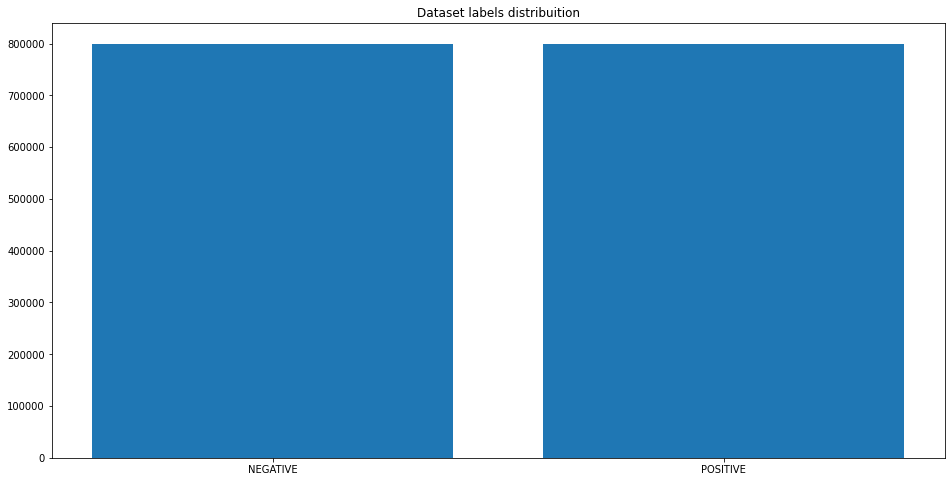

In [17]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [18]:
stemmer = SnowballStemmer("english")

In [19]:
stop_words = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
            'youv', 'your', 'yours', 'yourself', 'yourselves','ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 
              'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 
              'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 
              'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 
              'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 
              'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 
              'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 
              'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 
              'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 
              'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 
              'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 
              'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 
              'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 
              'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 
              'further', 'was', 'here', 'than','shes','',"I'm","I"]

for i in stop_words:
  if stop_words.count(i) > 1:
    stop_words.remove(i)

In [20]:
#Clear the nosiy value
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [21]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 58 s, sys: 355 ms, total: 58.4 s
Wall time: 58.3 s


In [22]:
processed_reviews=df.text.values

### Word Cloud for positive and negative reviews

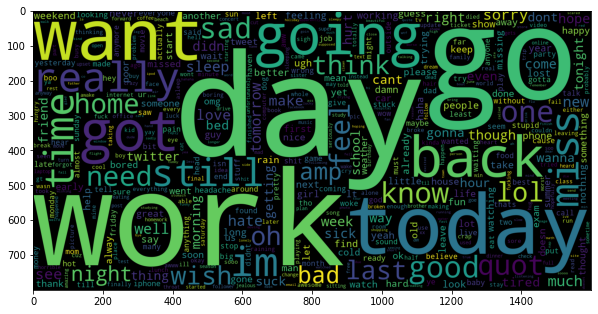

In [23]:
#Plot the negative reviews word-cloud
neg_reviews = processed_reviews[:800000]
plt.figure(figsize = (10,10))
neg_WordCloud = WordCloud(max_words = 500 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(neg_reviews))
plt.imshow(neg_WordCloud)

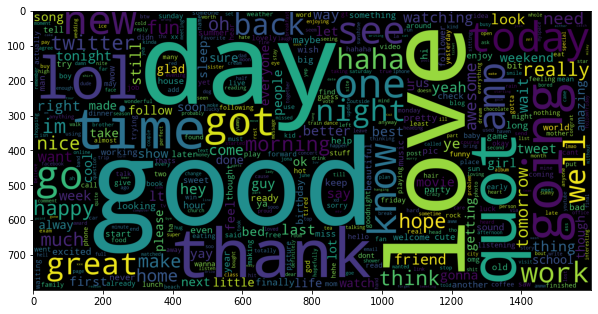

In [24]:
#Plot the positive reviews word-cloud
pos_reviews = processed_reviews[800000:]
plt.figure(figsize = (10,10))
neg_WordCloud = WordCloud(max_words = 500 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(pos_reviews))
plt.imshow(neg_WordCloud)

### Frequency of most common word in postive and negative reviews

In [25]:
def get_freqeuncy(df,label):
  stop_words = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
            'youv', 'your', 'yours', 'yourself', 'yourselves','ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 
              'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 
              'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 
              'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 
              'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 
              'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 
              'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 
              'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 
              'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 
              'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 
              'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 
              'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 
              'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 
              'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 
              'further', 'was', 'here', 'than','shes','',"I'm","I","u", "go", "get", "today","going","really","got","im","day","one","amp"]
  for i in stop_words:
    if stop_words.count(i) > 1:
      stop_words.remove(i)
  words=[]
  reviews=df[df['target']==label]['text'].values
  for review in reviews:
    x = review.split()
    words.append(x)
  combine_words = [j for i in words for j in i]
  nonstop_words=[item for item in combine_words if item not in stop_words]

  dic = collections.Counter(nonstop_words)
  sorted_dic = dict(sorted(dic.items(), key=operator.itemgetter(1),reverse=True))
  top=[]
  for i in range(10):
    top.append(list(sorted_dic.items())[i])
  return top

In [26]:
#Most common word in positive reviews
top_pos=get_freqeuncy(df,'POSITIVE')
top_pos

[('good', 62119),
 ('love', 47713),
 ('quot', 45910),
 ('like', 37519),
 ('lol', 36127),
 ('thanks', 34515),
 ('time', 30430),
 ('new', 26943),
 ('see', 25807),
 ('know', 25735)]

In [27]:
top_neg=get_freqeuncy(df,'NEGATIVE')
top_neg

[('work', 45427),
 ('like', 41048),
 ('back', 33078),
 ('miss', 30731),
 ('want', 29865),
 ('still', 29264),
 ('good', 29206),
 ('sad', 27918),
 ('time', 27521),
 ('know', 26314)]

In [28]:
#Plot the most commond word for neg and pos reviews
df_pos=pd.DataFrame(top_pos)
df_neg=pd.DataFrame(top_neg)

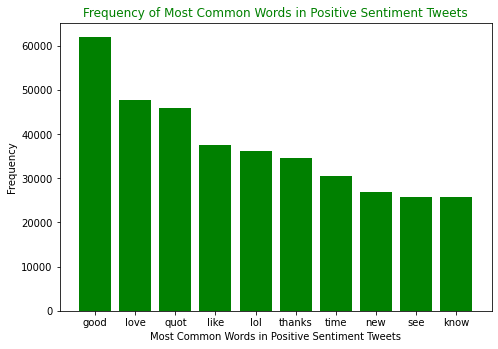

In [29]:
#Plot the most commond word for pos reviews 
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(list(df_pos[0]),list(df_pos[1]),color=('Green'))
plt.xlabel("Most Common Words in Positive Sentiment Tweets")
plt.ylabel("Frequency")
plt.title('Frequency of Most Common Words in Positive Sentiment Tweets',color=('Green'))
plt.show()

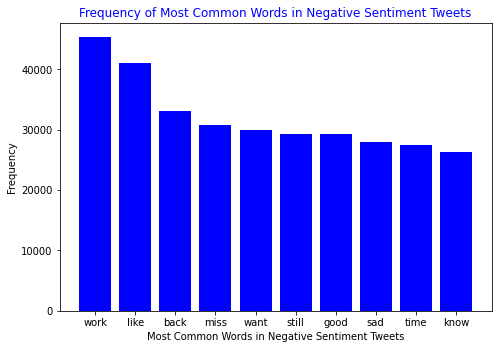

In [30]:
#Plot the most commond word for neg reviews 
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(list(df_neg[0]),list(df_neg[1]),color=('Blue'))
plt.xlabel("Most Common Words in Negative Sentiment Tweets")
plt.ylabel("Frequency")
plt.title('Frequency of Most Common Words in Negative Sentiment Tweets',color=('Blue'))
plt.show()

### Distribution of number of words.

In [31]:
len_reviews=[]
all_reviews=df['text'].values
for review in all_reviews:
  len_reviews.append(len(review))
df["length_of_text"]=np.array(len_reviews)

In [32]:
df

,target,ids,date,flag,user,text,length_of_text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day,44
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...,69
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...,52
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire,32
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see,16
...,...,...,...,...,...,...,...
1599995,POSITIVE,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,woke school best feeling ever,29
1599996,POSITIVE,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,thewdb com cool hear old walt interviews,40
1599997,POSITIVE,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,ready mojo makeover ask details,31
1599998,POSITIVE,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,happy 38th birthday boo alll time tupac amaru ...,52


In [33]:
df['length_of_text'].describe()

count    1.600000e+06
mean     4.281550e+01
std      2.437255e+01
min      0.000000e+00
25%      2.300000e+01
50%      3.900000e+01
75%      6.000000e+01
max      1.890000e+02
Name: length_of_text, dtype: float64

2021-04-13 17:43:24,641 : INFO : NumExpr defaulting to 2 threads.


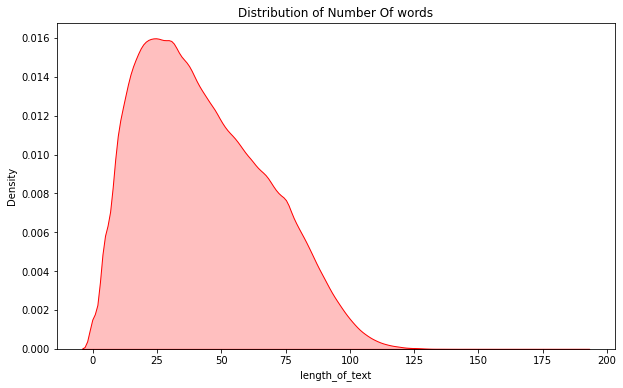

In [34]:
# number of words distribution plot is right skewed
plt.figure(figsize=(10,6))
p1=sns.kdeplot(df['length_of_text'], shade=True, color="r").set_title('Distribution of Number Of words')

# Split Dataset and Data Augmentation

In [35]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
df_train=df_train.sample(frac=1)
df_test=df_test.sample(frac=1)
df_train=df_train[:25000]
df_test=df_test[:3000]
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 25000
TEST size: 3000


In [36]:
#Data Augmentation split training dataset
df_train_1=df_train[:20000]
df_train_2=df_train[20000:]

In [37]:
len(df_train_2)

5000

In [38]:
def augmentor(new_data_df):
    aug = naw.SynonymAug()
    augment_texts=[]
    for column in new_data_df:
        columnSeriesObj=new_data_df['text']
        texts=columnSeriesObj.values
    for i in range(len(texts)):
        new_text= aug.augment(texts[i])
        augment_texts.append(new_text)
    for i in range(len(new_data_df)):
        new_data_df["text"].values[i]=augment_texts[i]

#augmentation
aug = naw.SynonymAug()
for column in df_train_2:
    columnSeriesObj=df_train_2['text']
    texts=columnSeriesObj.values

In [39]:
augment_texts=[]
for i in range(len(texts)):
    new_text= aug.augment(texts[i])
    augment_texts.append(new_text)


In [40]:
for i in range(len(df_train_2)):
    df_train_2["text"].values[i]=augment_texts[i]

In [41]:
df_train_2

,target,ids,date,flag,user,text,length_of_text
367975,NEGATIVE,2049361357,Fri Jun 05 16:44:50 PDT 2009,NO_QUERY,kenniko,user doesn exist twitter issues,31
658950,NEGATIVE,2241813412,Fri Jun 19 11:24:45 PDT 2009,NO_QUERY,RheaMillette,aaah killed hugest spider ever see crude unadu...,86
587162,NEGATIVE,2216220262,Wed Jun 17 19:11:40 PDT 2009,NO_QUERY,Holliday10,ah brian hope moving well least see to it one ...,55
454640,NEGATIVE,2070696676,Sun Jun 07 18:08:41 PDT 2009,NO_QUERY,samietz,cant believe bad hurt back,26
295119,NEGATIVE,1996781265,Mon Jun 01 15:40:48 PDT 2009,NO_QUERY,HB79Honor,wish could stay longer toy nigh midnight uk kn...,62
...,...,...,...,...,...,...,...
1248612,POSITIVE,1995873396,Mon Jun 01 14:10:49 PDT 2009,NO_QUERY,JenniPullen,welcome twtiter chum anxiously expect foremost...,87
642248,NEGATIVE,2235444830,Fri Jun 19 01:13:39 PDT 2009,NO_QUERY,reereefreak,says ayhah jeleq today,22
618343,NEGATIVE,2227485300,Thu Jun 18 13:15:21 PDT 2009,NO_QUERY,madisyncoy,cant belive two hours away,26
302341,NEGATIVE,1998949950,Mon Jun 01 19:23:34 PDT 2009,NO_QUERY,reverieBR,others masses anton friends,27


In [42]:
frames = [df_train_1, df_train_2]
df_train = pd.concat(frames)

In [43]:
df_train

,target,ids,date,flag,user,text,length_of_text
599314,NEGATIVE,2220643762,Thu Jun 18 03:36:44 PDT 2009,NO_QUERY,anisafifah,life easy,9
316446,NEGATIVE,2002407085,Tue Jun 02 04:07:15 PDT 2009,NO_QUERY,Buffalo_Souljaa,cannot watch anthink pc sound card well truly ...,52
170063,NEGATIVE,1962812559,Fri May 29 11:42:54 PDT 2009,NO_QUERY,wren,denial moving van parked blocks away,36
20188,NEGATIVE,1557017933,Sun Apr 19 01:33:13 PDT 2009,NO_QUERY,sebby_peek,alright talk mum talk later guess love,38
894591,POSITIVE,1692335653,Sun May 03 19:46:33 PDT 2009,NO_QUERY,rebecca_clark,haha funny texted saying hi watching doubt ton...,50
...,...,...,...,...,...,...,...
1248612,POSITIVE,1995873396,Mon Jun 01 14:10:49 PDT 2009,NO_QUERY,JenniPullen,welcome twtiter chum anxiously expect foremost...,87
642248,NEGATIVE,2235444830,Fri Jun 19 01:13:39 PDT 2009,NO_QUERY,reereefreak,says ayhah jeleq today,22
618343,NEGATIVE,2227485300,Thu Jun 18 13:15:21 PDT 2009,NO_QUERY,madisyncoy,cant belive two hours away,26
302341,NEGATIVE,1998949950,Mon Jun 01 19:23:34 PDT 2009,NO_QUERY,reverieBR,others masses anton friends,27






# Model Set Up




In [44]:
split_text_data=[]
df_train_text=df_train["text"].values
for text in df_train_text:
  x = text.split()
  split_text_data.append(x)

In [ ]:
#Word2 parameter
size_w2 = 300
windows_w2 = 7
w2v_model = gensim.models.word2vec.Word2Vec(size=size_w2, 
                                            window=windows_w2, 
                                            min_count=10, 
                                            workers=8)
w2v_model.build_vocab(split_text_data)
vocab_words = w2v_model.wv.vocab.keys()
number_words = len(vocab_words)
w2v_model.train(split_text_data, total_examples=len(split_text_data), epochs=16)
#Use tokenizer tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)
number_words = len(tokenizer.word_index)+1
#Keras parameter
length_of_sequence = 300
batch_size = 1000
pad_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=length_of_sequence)
pad_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=length_of_sequence)
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

encode_train = encoder.transform(df_train.target.tolist())
encode_test = encoder.transform(df_test.target.tolist())

encode_train = encode_train.reshape(-1,1)
encode_test = encode_test.reshape(-1,1)

embedding_matrix = np.zeros((number_words, size_w2))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]

In [46]:
model = Sequential()
model.add(Embedding(number_words, size_w2, weights=[embedding_matrix], input_length=length_of_sequence, trainable=False))
model.add(Bidirectional(LSTM(units=64, dropout=0.5, recurrent_dropout=0.2)))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer="rmsprop",
              loss='mean_squared_error',
              metrics=['accuracy'])
model.summary()

2021-04-13 17:52:12,070 : WARNING : Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-04-13 17:52:12,083 : WARNING : Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-04-13 17:52:12,099 : WARNING : Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          7830600   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               186880    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 8,017,609
Trainable params: 187,009
Non-trainable params: 7,830,600
_________________________________________________________________


In [47]:
history = model.fit(pad_train, encode_train,
                    batch_size=1000,
                    epochs=15,validation_data=(pad_test, encode_test),
                    verbose = 1)

Epoch 1/15
25/25 [==============================] - 54s 2s/step - loss: 0.2327 - accuracy: 0.6053 - val_loss: 0.2160 - val_accuracy: 0.6537
Epoch 2/15
25/25 [==============================] - 49s 2s/step - loss: 0.2164 - accuracy: 0.6507 - val_loss: 0.2092 - val_accuracy: 0.6717
Epoch 3/15
25/25 [==============================] - 48s 2s/step - loss: 0.2114 - accuracy: 0.6578 - val_loss: 0.2053 - val_accuracy: 0.6797
Epoch 4/15
25/25 [==============================] - 49s 2s/step - loss: 0.2075 - accuracy: 0.6724 - val_loss: 0.2024 - val_accuracy: 0.6883
Epoch 5/15
25/25 [==============================] - 48s 2s/step - loss: 0.2066 - accuracy: 0.6722 - val_loss: 0.2003 - val_accuracy: 0.6927
Epoch 6/15
25/25 [==============================] - 49s 2s/step - loss: 0.2027 - accuracy: 0.6798 - val_loss: 0.1989 - val_accuracy: 0.6910
Epoch 7/15
25/25 [==============================] - 48s 2s/step - loss: 0.2018 - accuracy: 0.6805 - val_loss: 0.1988 - val_accuracy: 0.6917
Epoch 8/15
25/25 [==

# Training Results

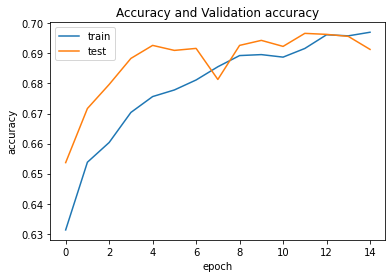

In [48]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy and Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

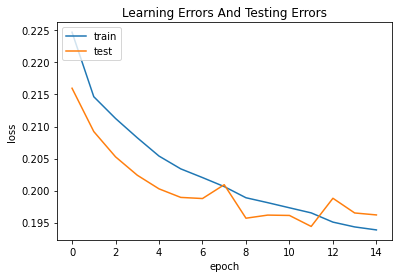

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning Errors And Testing Errors')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

# Predict New Text

In [50]:
def decoder(score):
  target = "NEUTRAL"
  if score <= 0.45:
    target = "NEGATIVE"
  elif score >= 0.55:
    target = "POSITIVE"
  return target
def predict(text):
    # Tokenize text
    pad_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=length_of_sequence)
    score = model.predict([pad_test])[0]
    target = decoder(score)
    return {"Target": target,"Socre":float(score)}

In [51]:
predict("Today is a good day to play basketball")

{'Socre': 0.7149856090545654, 'Target': 'POSITIVE'}

In [52]:
predict("I will not play basketabll with Tom becasue I hate him")

{'Socre': 0.28067338466644287, 'Target': 'NEGATIVE'}

In [53]:
predict("I play basketball.")

{'Socre': 0.5018175840377808, 'Target': 'NEUTRAL'}